<h2> 1) Setup and load Data <h3>

<h3> 1.1) Install Dependencies and setup 

In [1]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors b setting GPU memory consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h3> 1.2) Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data'

In [7]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in extension list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with Image {}'.format(image_path))

<h3> 1.3) Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
# Creating a image dataset using keras
data = tf.keras.utils.image_dataset_from_directory('data')

Found 148 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [14]:
# Labels for the images
# class 1 = sad
# class 0 = happy
batch[1]

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

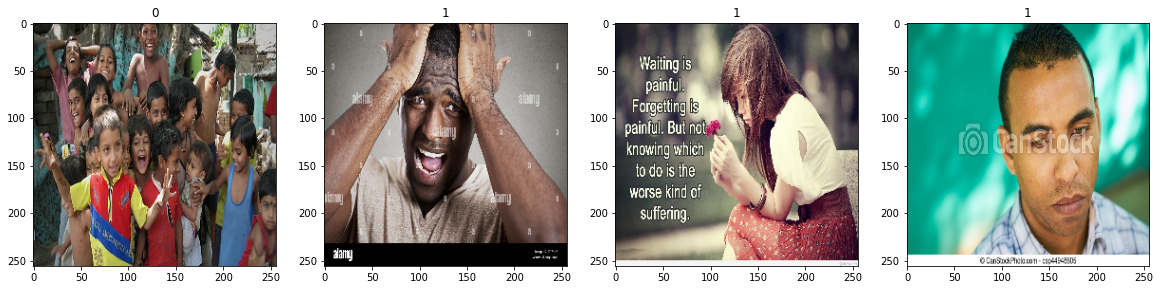

In [15]:
# Visualizing the dataset
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

<h2> 2) Preprocess Data <h3>

<h3> 2.1) Scale data

In [16]:
# Scaling is done for optimization for the deep learning model
# We scale the image numpy array vals to be between 0 and 1
scaled_data = data.map(lambda x, y: (x/255, y))

In [17]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [18]:
scaled_batch = scaled_iterator.next()

In [19]:
scaled_batch[0].max()

1.0

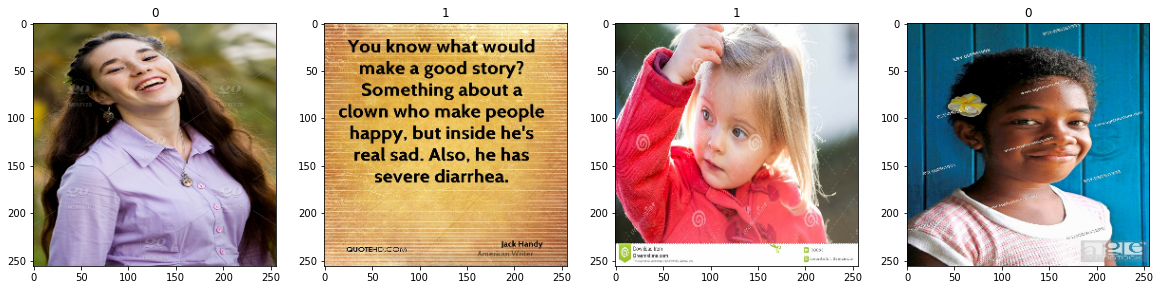

In [20]:
# Visualizing the scaled dataset
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

<h3> 2.2) Split data

In [21]:
# No of batches
len(data)

5

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

<h2> 3) Deep Learning Model <h3>

<h3> 3.1) Build the deep learning model 

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
# Adding layers to the NN
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

<h3> 3.2) Train the model

In [29]:
logdir = 'logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 23s 2s/step - loss: 343.1234 - accuracy: 0.4271 - val_loss: 142.3687 - val_accuracy: 0.4062
Epoch 2/20
3/3 [==============================] - 4s 1s/step - loss: 105.9582 - accuracy: 0.4688 - val_loss: 38.1785 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 4s 1s/step - loss: 13.1087 - accuracy: 0.6250 - val_loss: 13.4576 - val_accuracy: 0.4688
Epoch 4/20
3/3 [==============================] - 4s 1s/step - loss: 6.5788 - accuracy: 0.6146 - val_loss: 1.0489 - val_accuracy: 0.7188
Epoch 5/20
3/3 [==============================] - 4s 1s/step - loss: 0.5411 - accuracy: 0.8438 - val_loss: 0.7210 - val_accuracy: 0.7500
Epoch 6/20
3/3 [==============================] - 4s 1s/step - loss: 0.4454 - accuracy: 0.7917 - val_loss: 0.1927 - val_accuracy: 0.9375
Epoch 7/20
3/3 [==============================] - 4s 1s/step - loss: 0.3004 - accuracy: 0.8750 - val_loss: 0.3574 - val_accuracy: 0.8438
Epoch 8/20
3/3 [===============

In [32]:
model.save('deepCnnModel.h5')

<h3> 3.3) Plot Performance

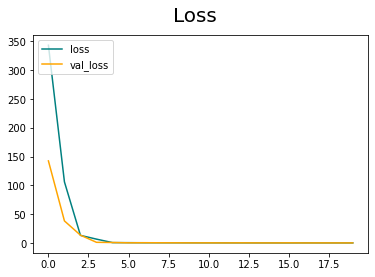

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

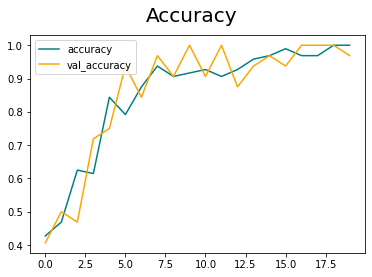

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<h2> 4) Evaluate Performance <h3>

<h3> 4.1) Evaluate

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 868ms/step


In [38]:
# Printing the evaluation values
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


<h3> 4.2) Testing

In [39]:
import cv2

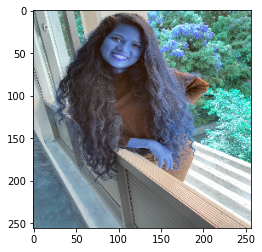

In [55]:
sad_img = cv2.imread('resources/happytest.jpg')

temp_sad = tf.image.resize(sad_img, (256,256))
resize_sad = temp_sad.numpy().astype(int)

plt.imshow(resize_sad)
plt.show()

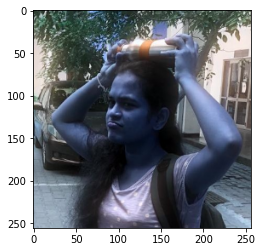

In [56]:
happy_img = cv2.imread('resources/sadtest.jpg')

temp_happy = tf.image.resize(happy_img, (256,256))
resize_happy = temp_happy.numpy().astype(int)

plt.imshow(resize_happy)
plt.show()

In [60]:
yhat_testing = model.predict(np.expand_dims(resize_sad/255, 0))

1/1 [==============================] - 0s 24ms/step


In [61]:
yhat_testing

array([[0.5078044]], dtype=float32)

In [62]:
if yhat_testing > 0.5:
    print(f'Predicted Class is Sad')
else:
    print(f'Predicted Class is Happy')

Predicted Class is Sad


<h2> 5) Save the Model <h3>

<h3> 5.1) Saving the model using keras

In [63]:
from tensorflow.keras.models import load_model

In [64]:
model.save(os.path.join('models', 'happysadCnnImgClassifier.h5'))

In [65]:
new_model = load_model(os.path.join('models', 'happysadCnnImgClassifier.h5'))

In [66]:
yhatNew = new_model.predict(np.expand_dims(resize_happy/255, 0))

1/1 [==============================] - 0s 94ms/step


In [67]:
yhatNew

array([[0.4983107]], dtype=float32)